In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [21]:

def get_distance(point1, point2):
    if len(point1) != 2 or len(point2) != 2:
        return 'please provide x,y coordinates for each point'
    x_1 = point1[0]
    y_1 = point1[1]
    x_2 = point2[0]
    y_2 = point2[1]

    distance = np.sqrt((x_1 - x_2) ** 2 + (y_1 - y_2) ** 2)
    return distance

# check if the path intersects with the obstacles in configuration space.
def check_collision(traj, c_space_obs):
    collision_points  = []
    for point in traj:
        if point in c_space_obs:
            collision_points.append(point)
    if len(collision_points) == 0:
        return  'No collision happened'
    else:
        return  'Collision happened'


# generate a path between the start point and end point. [point1, point2, point3 ..... end_point]
def generate_path(start, end):
    result = []
    dx, dy = end[0] - start[0], end[1] - start[1]
    if dx == 0:
        result = [(start[0], start[1] + i) for i in range(1, dy + 1)]
    else:
        for i in range(1, abs(dx) + 1):
            node = (start[0] + int(i * abs(dx) / dx), start[1] + int(i * dy / abs(dx)))
            result.append(node)
    return result


# link two nodes in the graph
def link_points(graph, node1, node2):
    if node1 not in graph:
        graph[node1] = []
    (graph[node1]).append(node2)
    if node2 not in graph:
        graph[node2] = []
    (graph[node2]).append(node1)
    return graph


# use DFS to find all paths in the graph.
def init_to_goal(graph, init_point, goal_point, path=[]):
    path = path + [init_point]
    if init_point not in graph:
        return []
    if init_point == goal_point:
        return [path]
    all_paths = []
    for node in graph[init_point]:
        if node not in path:
            all_paths.extend(init_to_goal(graph, node, goal_point, path))
    return all_paths


In [12]:
def RRT_Tree(init_pos, goal_pos, grid_set, obs, max_iter, max_dis_iter):
    traj = [init_pos]
    connect = []
    grid_length, grid_width = grid_set
    iter_num = 0
    found_goal = False
    while iter_num < max_iter and not found_goal  :
        rand_valid = False

        # check if robot reaches the goal point
        if goal_pos in traj:
            found_goal = True

        # generate random points with the grid
        rand_point = (random.randint(0, grid_width), random.randint(0, grid_length))

        # check if the random point is in obstacles.
        if rand_point in obs:
            continue

        # find the closest point to rand point
        dis = []
        for point in traj:
            dis.append(get_distance(rand_point, point))
        closest_dis = min(dis)
        closest_index = dis.index(closest_dis)
        closest_point = traj[closest_index]

        if closest_dis > max_dis_iter:
            continue

        # check if the line straight line between closest point and rand point intersects with obstacles
        closest_path = generate_path([closest_point[0], closest_point[1]], [rand_point[0], rand_point[1]])

        meet_obs = False
        for point in closest_path:
            if point in obs:
                meet_obs = True

        if meet_obs:
            continue

        rand_valid = True
        traj.append(rand_point)
        connect.append((closest_point, rand_point))

        # if the random point is close enough to the goal point, add connect directly between em and break the loop.
        if rand_valid:
            check_dis = get_distance(rand_point, goal_pos)
            if check_dis < max_dis_iter:
                traj.append(goal_pos)
                connect.append((rand_point, goal_pos))
        iter_num += 1
    print(iter_num)
    return traj, connect


In [4]:
def create_env_map_conf(grid_width, grid_length, to_obs_dis):
    def get_obs(obs):
        obs_num = len(obs)
        # initialize the obstacle lists.
        obstacle =  [[] for i in range(obs_num)]
        ins_obstacle = [[] for i in range(obs_num)]
        for i in range(obs_num):
            obs_length = obs[i][0]
            obs_width = obs[i][1]
            obs_x = obs[i][2]
            obs_y = obs[i][3]
            for h in range(obs_x, obs_x + obs_width):
                obstacle[i].append((h, obs_y))
                obstacle[i].append((h, obs_y + obs_length))
            for j in range(obs_y, obs_y + obs_length):
                obstacle[i].append((obs_x, j))
                obstacle[i].append((obs_x + obs_width, j))
            for k in range(obs_x, obs_x + obs_width):
                for l in range(obs_y, obs_y + obs_length):
                    ins_obstacle[i].append((k, l))

        return obstacle, ins_obstacle

    obs = []
    obs1_length = 20
    obs1_width = 40
    obs2_length = 20
    obs2_width = 40
    obs1_x, obs1_y = 250, 300
    obs2_x, obs2_y = 250, 100

    obs.append((obs1_length, obs1_width, obs1_x, obs1_y))
    obs.append((obs2_length, obs2_width, obs2_x, obs2_y))

    obstacle, ins_obstacle = get_obs(obs)


    # get points those are not obstacles.
    no_obs_points = []
    for i in range(grid_width):
        for j in range(grid_length):
            for k in range(len(ins_obstacle)):
                if (i, j) not in ins_obstacle[k]:
                     no_obs_points.append((i, j))

    # transfer to the configuration space and get the obstacle points in c space.
    obs_num = len(obs)
    c_space_border_overlap = [[] for i in range(obs_num)]
    for point in no_obs_points:
        for i in range(len(obstacle)):
            for obstacle_point in obstacle[i]:
                if get_distance(point, obstacle_point) == to_obs_dis:
                    c_space_border_overlap[i].append(point)

    c_space_border = []
    for i in range(len(c_space_border_overlap)):
        max_x = max(c_space_border_overlap[i], key=lambda item: item[0])[0]
        min_x = min(c_space_border_overlap[i], key=lambda item: item[0])[0]
        max_y = max(c_space_border_overlap[i], key=lambda item: item[1])[1]
        min_y = min(c_space_border_overlap[i], key=lambda item: item[1])[1]
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                c_space_border.append((x, y))

    border = []
    for i in range(grid_length):
        border.append((0, i))
        border.append((grid_width, i))
    for i in range(grid_width):
        border.append((i, 0))
        border.append((i, grid_length))

    plt.figure(figsize=(15, 10))
    for border_point in border:
        plt.scatter(border_point[0], border_point[1], c='gray', marker='.')
    for c_space_obs_point in c_space_border:
        plt.scatter(c_space_obs_point[0], c_space_obs_point[1], c='gray', marker='.')
    plt.grid()
    plt.show()
    plt.savefig('2obs.jpg')

    return border, c_space_border

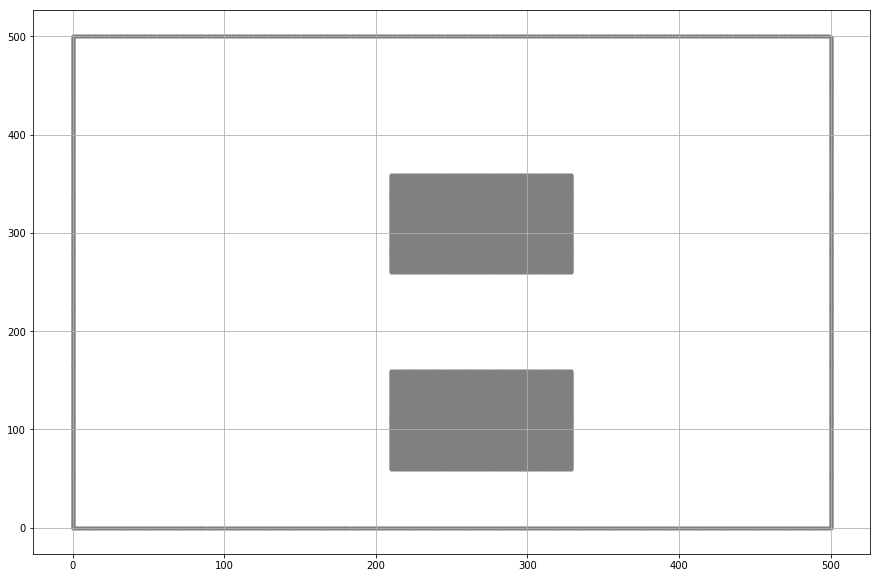

<Figure size 432x288 with 0 Axes>

In [5]:
    init_pos = (100, 100)
    goal_pos = (100, 100)
    grid_set = (500, 500)
    max_iter = 1000
    max_dis_iter = 100

    border, c_space_border = create_env_map_conf(grid_set[0], grid_set[1], 40)

In [6]:
init_point = (100, 100)
goal_point = (400, 300)

In [13]:
traj_points, connect = RRT_Tree(init_point, goal_point, grid_set, c_space_border, max_iter, max_dis_iter)

114


In [17]:
print(len(connect))

115


In [18]:
p_x = []
p_y = []
for c  in connect:
    for point in c:
        p_x.append(point[0])
        p_y.append(point[1])

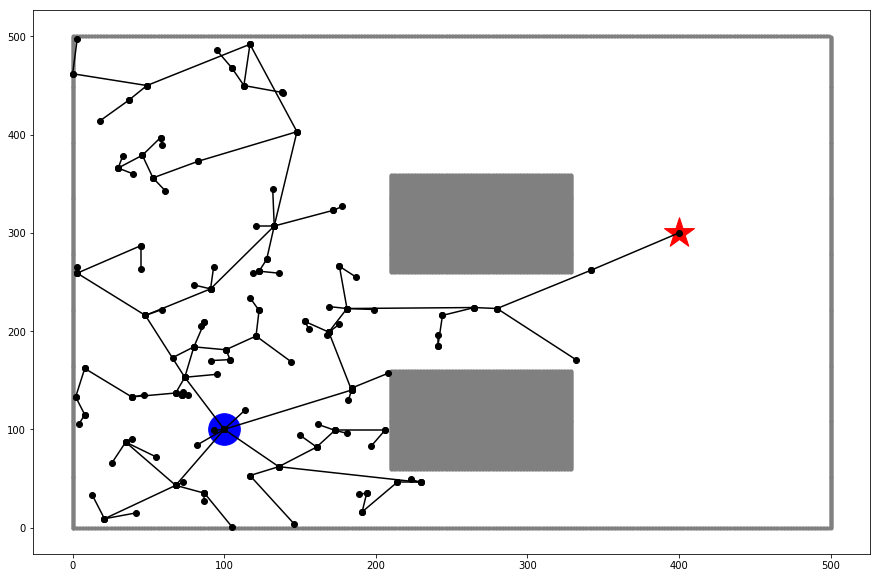

In [20]:
plt.figure(figsize=(15, 10))
for b_point in border:
    plt.scatter(b_point[0], b_point[1], c='gray', marker='.')
for obs_point in c_space_border:
    plt.scatter(obs_point[0], obs_point[1], c='gray', marker='.')
for k in range(0, len(p_x), 2):
    plt.plot(p_x[k:k+2], p_y[k:k+2], 'ko-')
plt.scatter(init_point[0], init_point[1], c='blue', marker='o', s=1000)
plt.scatter(goal_point[0], goal_point[1], c='red', marker='*', s=1000)
plt.show()

In [22]:
def plot_path(connect, init_point, goal_point, border, obs):
    p_x, p_y = [], []
    for c in connect:
        for p in c:
            p_x.append(p[0])
            p_y.append(p[1])

    graph = {}
    for p1, p2 in connect:
        link_points(graph, p1, p2)

    all_paths = init_to_goal(graph, init_point, goal_point)
    traj_x, traj_y = [], []
    for point in all_paths[0]:
        traj_x.append(point[0])
        traj_y.append(point[1])
    plt.figure(figsize=(15, 10))
    for i in range(0, len(traj_x), 2):
        plt.plot(traj_x[i:i+2], traj_y[i:i+2], 'ro-', linewidth=5)
        plt.plot(traj_x[i+1:i+3], traj_y[i+1:i+3], 'ro-', linewidth=5)
    for b_point in border:
        plt.scatter(b_point[0], b_point[1], c='gray', marker='.')
    for obs_point in obs:
        plt.scatter(obs_point[0], obs_point[1], c='gray', marker='.')
    for k in range(0, len(p_x), 2):
        plt.plot(p_x[k:k+2], p_y[k:k+2], 'ko-')
    plt.scatter(init_point[0], init_point[1], c='blue', marker='o', s=1000)
    plt.scatter(goal_point[0], goal_point[1], c='red', marker='*', s=1000)
    plt.grid()
    plt.show()

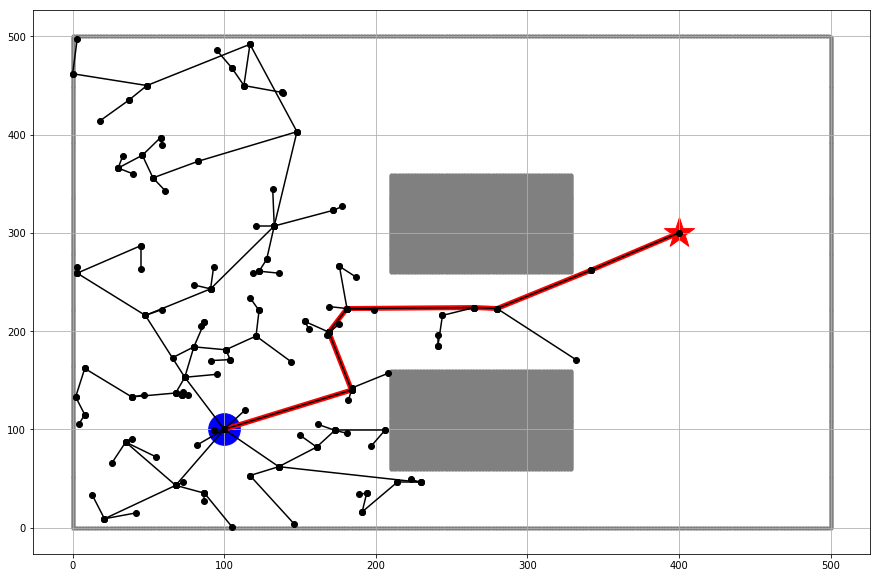

In [23]:
plot_path(connect, init_point, goal_point, border, c_space_border)